# Patryk Barkowski - projekt
---
### Analiza Danych Elektrofizjologicznych 2017
---
Witam w moim królestwie.<br>Postaram się możliwie uprzyjemnić podróż przez niniejszą pracę - będzie ładnie, wizualnie i - **mam nadzieję!** - przejrzyście. Ponizej spis treści, gdybyśmy się mieli pogubić:
1. przygotowanie do pracy
2. wczytanie pliku
3. filtrowanie
4. pozycje elektrod (montaż)
5. epokowanie
6. ICA
7. porównania w domenie czasu: ERPy
8. porównania w domenie częstotliwości: widma

## 0. przygotowanie do pracy

Na dzień dobry klasyczne i zawsze oczekiwane - powitajmy **os** oraz **mne**!

In [1]:
import os
import mne

Upewaniam się czy plik (wybrałem **CAT110 20131108 2040002.raw**) jest obecny w folderze:

In [4]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 045A-06F7

 Directory of C:\Users\Machina\Desktop\analizadanycheeg\projekt

03.07.2017  18:50    <DIR>          .
03.07.2017  18:50    <DIR>          ..
03.07.2017  17:27    <DIR>          .ipynb_checkpoints
01.07.2017  19:11         1˙125˙157 12.ipynb
23.05.2017  21:53        51˙829˙776 CAT110 20131108 2040002.raw
03.07.2017  18:02           401˙707 cos1.png
03.07.2017  18:00           410˙550 inne_1.png
03.07.2017  18:01           408˙701 inne_2.png
03.07.2017  18:07           350˙340 inne_3.png
03.07.2017  17:59           397˙071 miesnie_1.png
03.07.2017  18:00           432˙971 miesnie_2.png
03.07.2017  18:02           407˙601 miesnie_3.png
03.07.2017  18:04           417˙949 miesnie_4.png
03.07.2017  18:04           413˙187 miesnie_5.png
03.07.2017  18:03           405˙863 mruganie_1.png
03.07.2017  18:03           393˙753 mruganie_2.png
03.07.2017  18:09           360˙486 mruganie_3.png
03.07.2017  08:28                45 

Na koniec żeby nie męczyć się za mocno z kopiowaniem nazwy, zrobię zmienną z nazwą pliku:

In [5]:
plik = "CAT110 20131108 2040002.raw"

## 1. wczytywanie pliku


Klasyczna komenta dla wczytaniu pliku z rozszerzeniem .raw:

In [6]:
dane = mne.io.read_raw_egi(plik, preload=True)

Reading EGI header from CAT110 20131108 2040002.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
Reading 0 ... 177498  =      0.000 ...   709.992 secs...


Sprawdzmy szybko ile kanałów ma nasz sygnał:

In [7]:
dane

<RawEGI  |  CAT110 20131108 2040002.raw, n_channels x n_times : 73 x 177499 (710.0 sec), ~99.0 MB, data loaded>

73 kanały, nieźle!

In [8]:
%matplotlib inline

In [13]:
%matplotlib


Using matplotlib backend: Qt5Agg


## 2. filtrowanie


Zastosuję następujące filtry: górno-przepustowy 1Hz oraz low transition bandwith 0,25Hz.

Dodatkowo, zgodnie z wskazówkami z zajęć, kopiuję dane tak, aby nie ingerować w oryginalny surowy sygnał.

In [9]:
dane2 = dane.copy();
dane2.filter(1, None, l_trans_bandwidth=0.25);

Setting up high-pass filter at 1 Hz
Filter length of 6600 samples (26.400 sec) selected


Porównam sobie sygnał sprzed filtrowania...

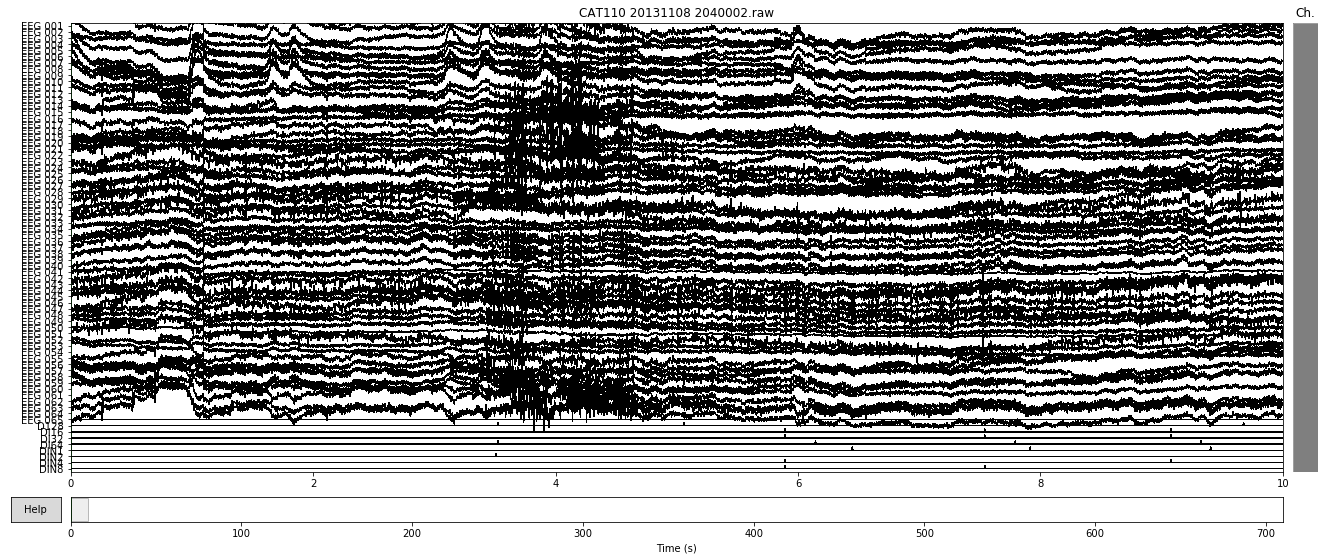

In [10]:
dane.plot(start=0, n_channels=73);

... oraz efekt po filtowaniu, upewniam się, że sygnał zauważanie mniej "pływa":

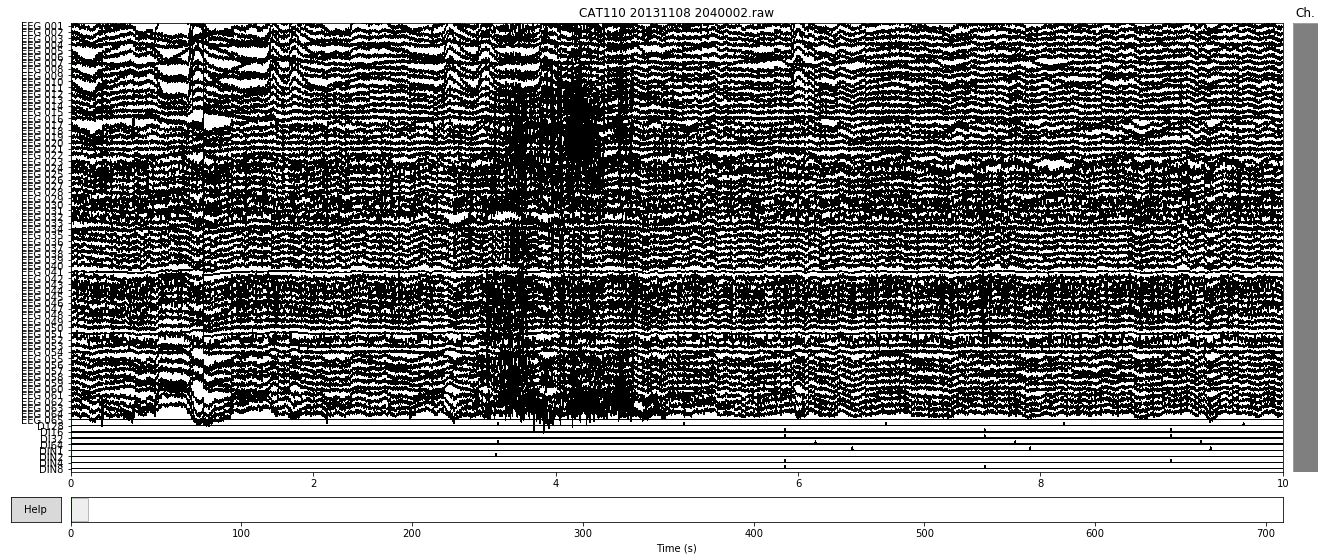

In [11]:
dane2.plot(start=0, n_channels=73);

## 3. pozycje elektrod


Ponieważ kanały nazywające się np. EEG033 nie dają nam jakiejkolwiek informacji, muszę wczytać odpowiedni montaż. Zgodnie z instrukcją, będzie to **GSN-HydroCel-65_1.0**. Nie będę tworzył zmiennych jak na zajęciach, ponieważ później nie przydadzą mi się w projekcie.

In [12]:
mne.channels.read_montage('GSN-HydroCel-65_1.0')

<Montage | GSN-HydroCel-65_1.0 - 68 channels: FidNz, FidT9, FidT10 ...>

Zmieniam nazwy kanałów zgodnie z instrukcją z "bolączek", jednocześniej upewniając się, że zmiana jest zgodna z tym, co chciałem osiągnąć - czyli zmianą z EEG001 na E1, EEG02 na E2 i tak dalej:

In [13]:
from mypy.chans import correct_egi_channel_names

correct_egi_channel_names(dane2)
print(dane2.ch_names[:8])

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']


In [14]:
dane2.set_montage(mne.channels.read_montage('GSN-HydroCel-65_1.0'))

Szybko upewnię się, że mam nowe nazwy:

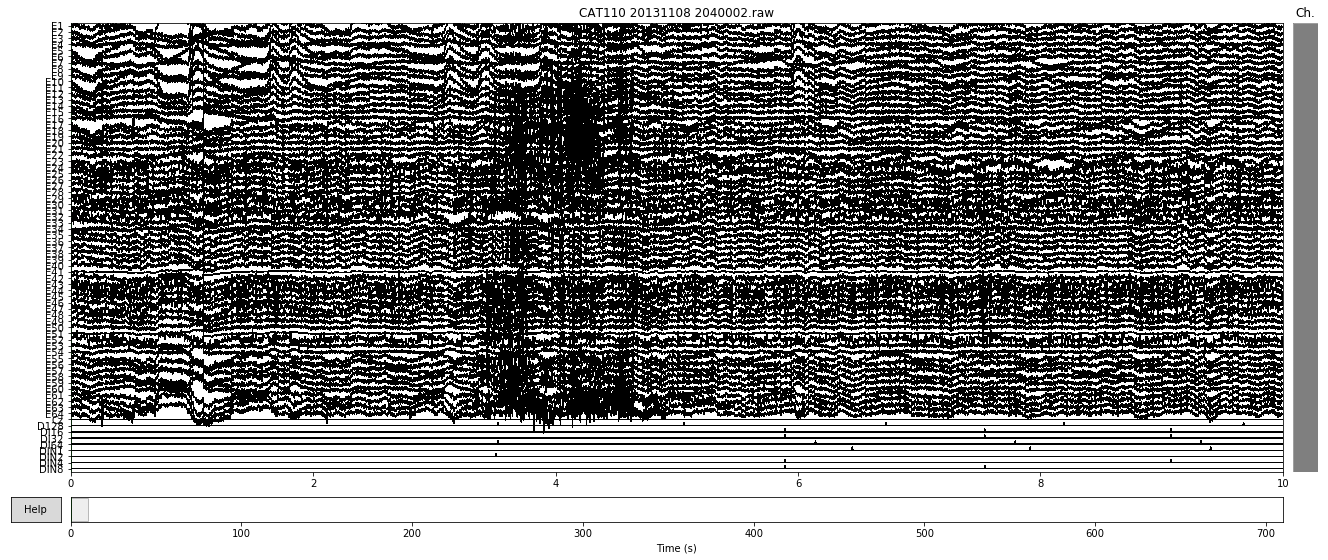

In [16]:
dane2.plot(start=0, n_channels=73);

Sukces! Czas na..

## 4. epokowanie
### 4.1 tworzenie wydarzeń

Dla przypomnienia oraz ułatwienia kolejnych etapów pracy, szybka przypominajka wartości wydarzeń w procedurze "twarze i samochody":
* 1 - osoba badana wciska strzałkę w lewo
* 2 - osoba badana wciska strzałkę w prawo
* 3 - osoba badana wciska spację
* 36 - na ekranie prezentowany jest samochód pod kątem 0 stopni
* 40 - na ekranie prezentowany jest samochód pod kątem 90 stopni
* 44 - na ekranie prezentowany jest samochód pod kątem 180 stopni (do góry "nogami")
* 52 - na ekranie prezentowana jest twarz pod kątem 0 stopni
* 56 - na ekranie prezentowana jest twarz pod kątem 90 stopni
* 60 - na ekranie prezentowana jest twarz pod kątem 180 stopni (do góry nogami)
* 128 - na erkanie pojawia się krzyżyk fiksacji I jeszcze kilka innych wydarzń, które nie są tak ważne.

Najpierw wyciagnę informację z kanałów DIN ze zmianą na konkretne, wyżej opisane wydarzenia:

In [17]:
import mypy
wydarzenia = mypy.events.get_events_from_din(dane2)

A następnie usuwam niepotrzebne już kanały DIN:

In [18]:
dane2.drop_channels(['DIN1', 'DIN2', 'DIN4', 'DIN8', 'DI16', 'DI32', 'DI64', 'D128'])

<RawEGI  |  CAT110 20131108 2040002.raw, n_channels x n_times : 65 x 177499 (710.0 sec), ~88.1 MB, data loaded>

Obecna wartość w n_channels=65, czyli z pierwotnych 73 wypadło 8 (tyle ile wyżej zdefiniowanych). So far so good!

### 4.2 tworzenie epok w oparciu o wydarzenia

Ważny moment: wybieram, które wydarzenia są dla mnie ważne. Dalej opiszę dlaczego wybrałem te konkretne, co będę ze sobą porównywał i tym podobne. Póki co poepokuję... wszystko związane z twarzami i samochodami. Będzie trochę pracy przy zaznaczniu złych epok, ale czego nie robi się w imię nauki? Epokuję po 0,5 sekundy przed i po bodźcu.

In [19]:
doepokowania = [36, 40, 44, 52, 56, 60, 128]

In [20]:
epoki = mne.Epochs(dane2, events=wydarzenia, event_id=doepokowania,
                   tmin=-0.5, tmax=0.5, preload=True)

825 matching events found
0 projection items activated
Loading data for 825 events and 251 original time points ...
0 bad epochs dropped


Super! 825! Epok! Do! Przeglądania!

### 4.3 przeglądanie złych epok i ich usuwanie

In [23]:
%matplotlib inline

In [38]:
%matplotlib

Using matplotlib backend: Qt5Agg


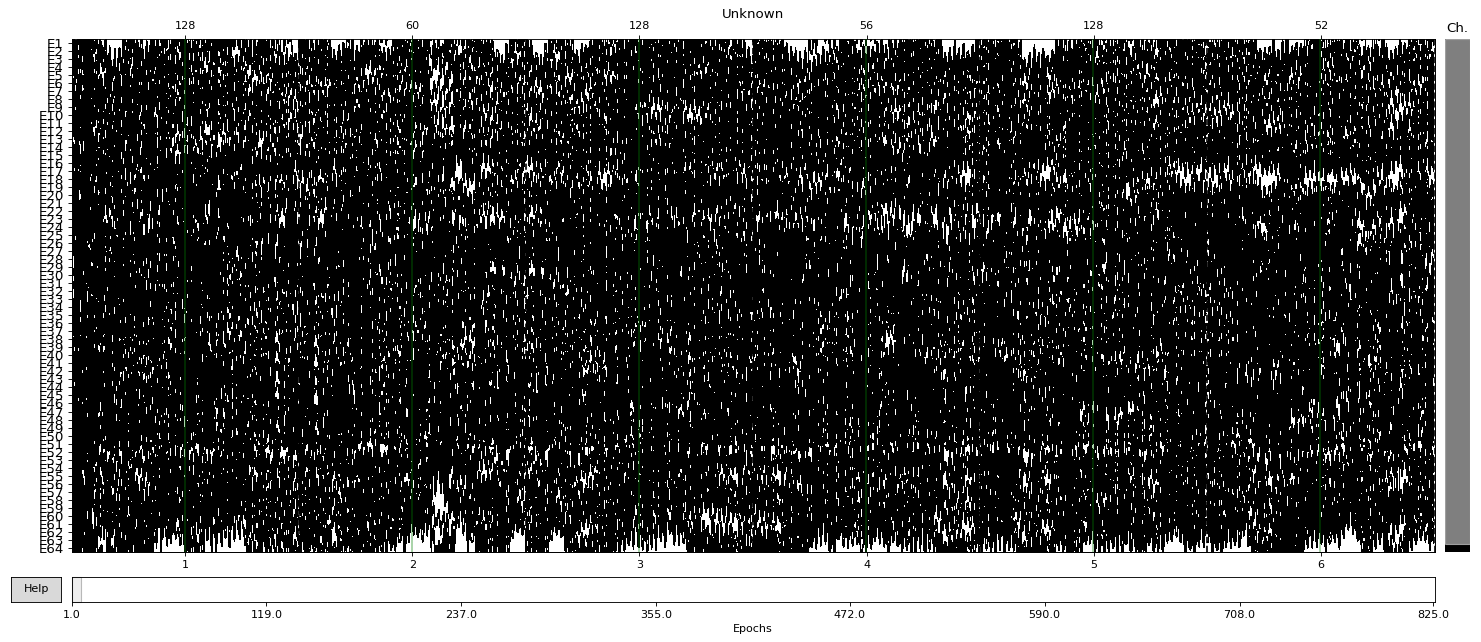

In [22]:
#przy pomocy %matplotlib znalazałem i zaznaczyłem epoki do wyrzucenia; 
#w kolejnych podejściach do projektu zapisałem numery epok, które wyrzuciłem następną po poniższej komendą
epoki.plot(n_channels=64, n_epochs=6);

In [ ]:
epochs.drop([0, 1, 3, 4, 10])

Cały sygnał jest całkiem ładny, jak na taką liczbę epok, zdecydowałem się wyrzucić dość mało. Duża w tym zasługa pominięciu mrugania - domyślam się, że przed ICA musiały być ciężkie czasy dla badaczy ręcznie sprawdzających całe sygnały.

#### **Przykład wyrzuconych epok** <br>
Niestety, wrzucam zrzuty ekranu, ponieważ próba pokazania tych epok w kodzie była bardzo "niewyraźna".

Pliki o nazwach * **miesnie_1, miesnie_2, miesnie_3, miesnie_4, miesnie_5** * zawierają przykładowe artefakty mieśniowe, jakie zaznaczałem do wyrzucenia, przy czym najlepiej widoczne są w 4 i 5. 

Pliki o nazwach ** *mruganie_1, mruganie_2, mruganie_3* ** - zawierają przykłady artefaktów związanych z mruganiem, które zdecydowałem się zostawić w sygnale, aby później usunąć je przy pomocy ICA. Zaznaczyłem je na czerwono tylko na chwilę, żeby zrobić zrzut, później odznaczałem.

Pliki o nazwach ** *ruchoczu_1, ruchoczu_2, ruchoczu_3* ** zawierają przykładowe artefakty ruchu oczu, jakie zaznaczałem do wyrzucenia, przy czym tych artefaktów byłem najmniej pewny - było bardzo mało charakterystycznych zapisów świadczących o tych artefaktach.

Pliki o nazwach ** *inne_1, inne_2, inne_3* ** - zawierają przykłady "dziwnych" odchyleń od sygnału, które zdecydowałem się odrzucić. Wiem, że w inne_3 mogłbym "wygasić" te dwie elektrody, ale w znaczej cześćci sygnału nie było z nimi problemu, dlatego zdecydowałem się je zostawić.

## 5. ICA
Jakby powiedział Mikołaj na zajęciach: "czas zająć się ICA i wyczyścić dobrze te dane."
### 5.1 dopasowanie ICA

Najpierw referencja do średniej:

In [24]:
epoki.set_eeg_reference()
epoki.apply_proj()

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but hasn't been applied yet. Use the .apply_proj() method function to apply projections.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<Epochs  |  n_events : 825 (all good), tmin : -0.5 (s), tmax : 0.5 (s), baseline : (None, 0), ~102.8 MB, data loaded,
 '128': 413, '36': 69, '40': 69, '44': 68, '52': 68, '56': 69, '60': 69>

In [25]:
from mne.preprocessing import ICA
ica = ICA(method='extended-infomax', n_components=0.99)
print(ica)

<ICA  |  no decomposition, fit (extended-infomax):  samples, no dimension reduction>


In [28]:
ica.fit(epoki)

Fitting ICA to data using 65 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by explained variance: 45 components
computing Extended Infomax ICA


<ICA  |  epochs decomposition, fit (extended-infomax): 207075 samples, 45 components, channels used: "eeg">

In [29]:
%matplotlib inline

In [45]:
%matplotlib

Using matplotlib backend: Qt5Agg


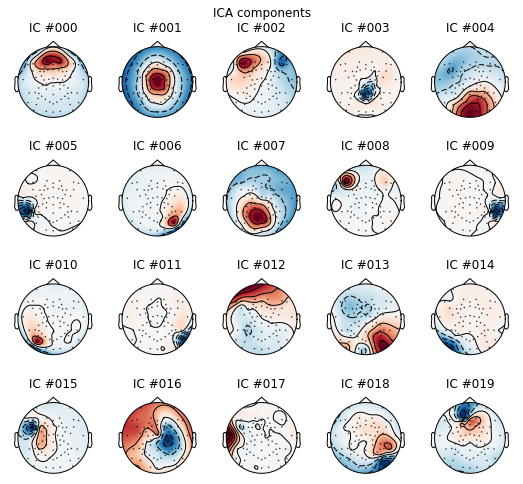

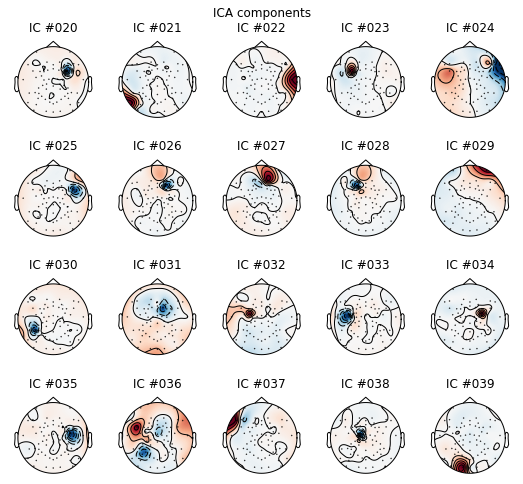

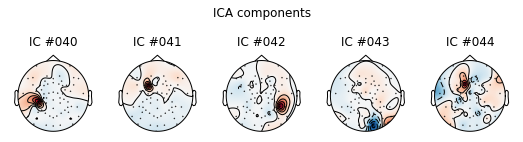

In [30]:
ica.plot_components(inst=epoki);

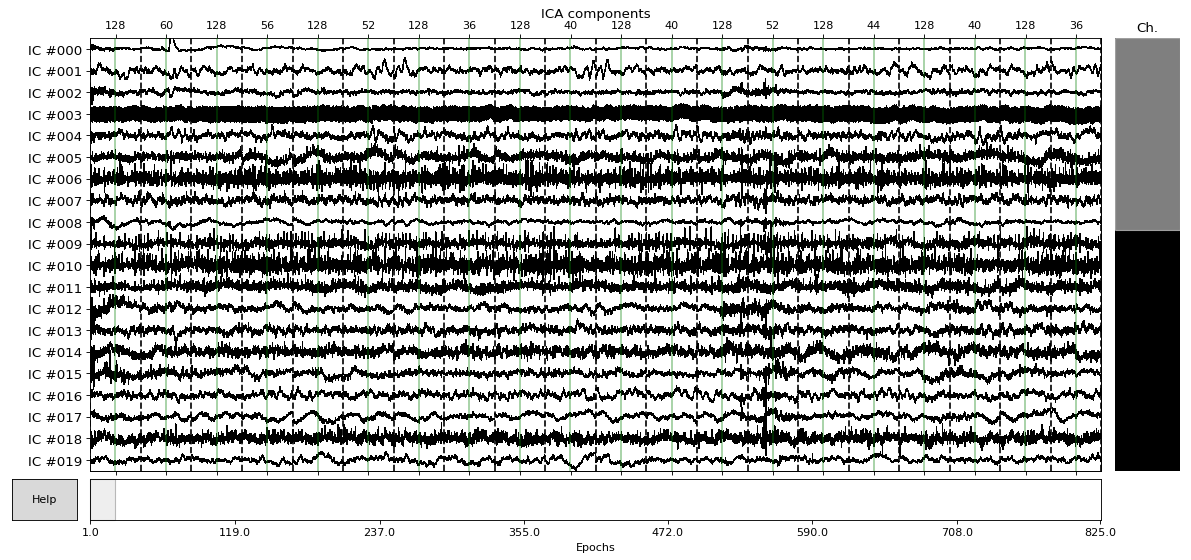

In [31]:
ica.plot_sources(epoki);

Na podstawie map cieplnych oraz plotu komponentów, decyduję się odrzucić powyższe, wskazane na czerwono.
Poniżej powody, dla których decydowałem się odrzucać dany komponent:

**Artefakt związany z oczyma - mruganie?**

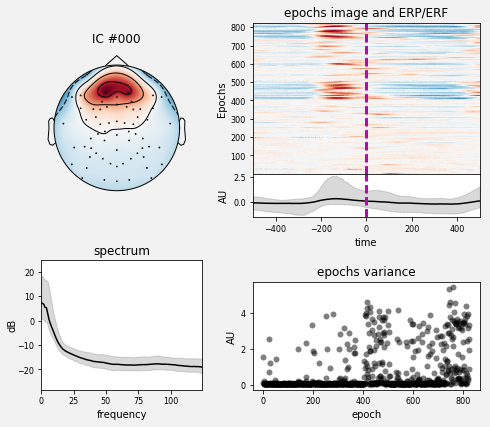

In [32]:
ica.plot_properties(picks=0, inst=epoki, image_args=dict(sigma=2.5));

**Artefakt związany z siecią:**

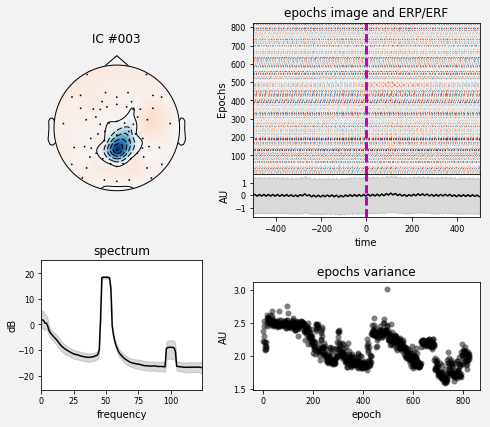

In [33]:
ica.plot_properties(picks=3, inst=epoki, image_args=dict(sigma=2.5));

**Ruchy horyzontalne oczu:**

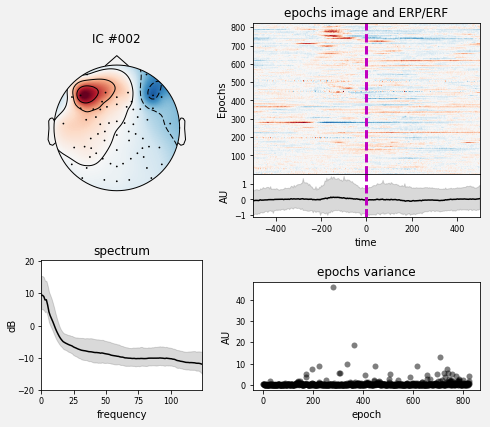

In [35]:
ica.plot_properties(picks=2, inst=epoki, image_args=dict(sigma=2.5));

**Artefakty mięśniowe i/lub zwiazane z jedną elektrodą:**

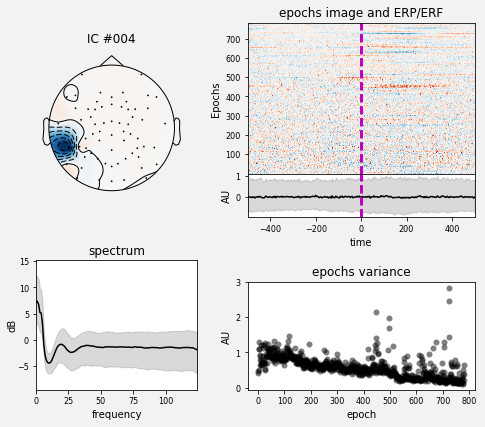

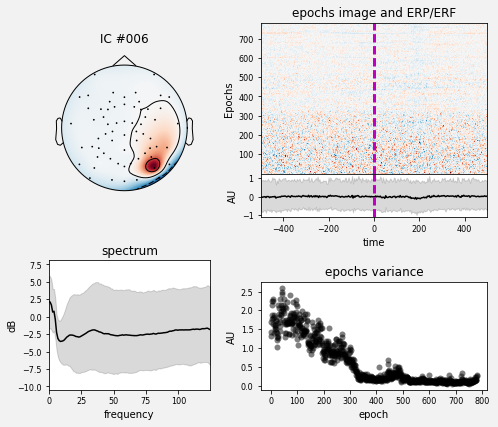

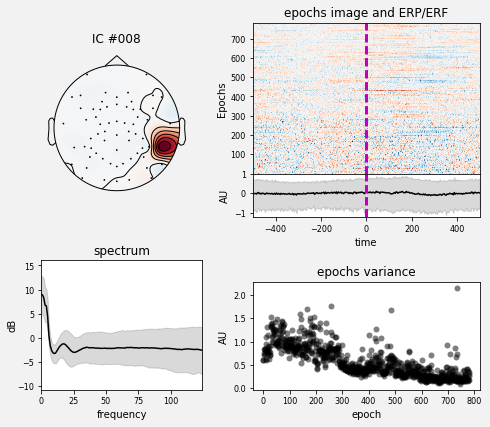

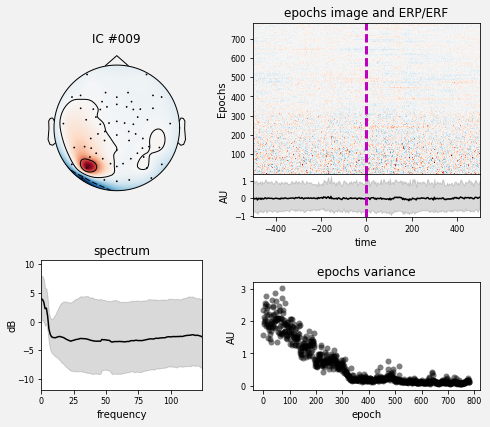

In [55]:
ica.plot_properties(picks=[4, 6, 8, 9], inst=epoki, image_args=dict(sigma=2.5));

**Artefakty mięśniowe:**

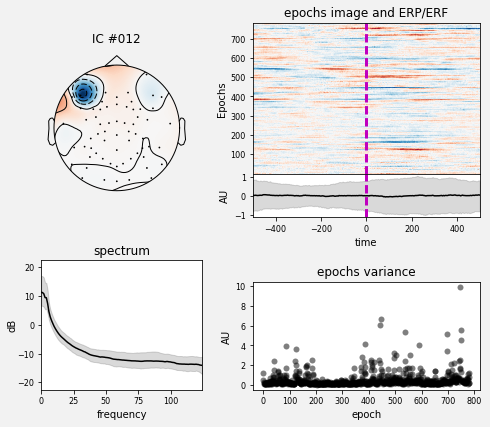

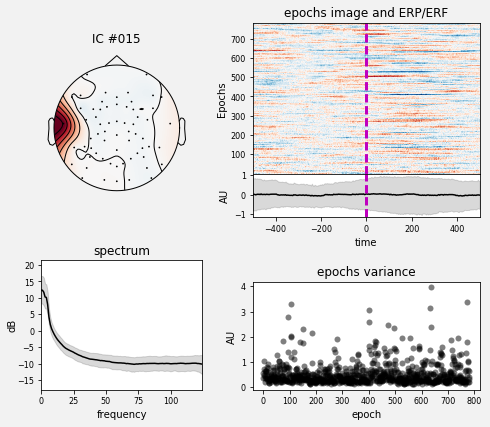

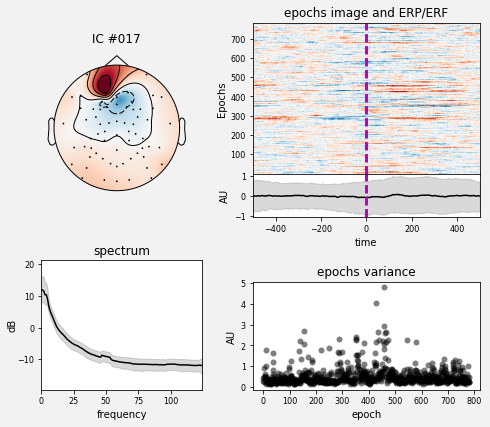

In [56]:
ica.plot_properties(picks=[12, 15, 17], inst=epoki, image_args=dict(sigma=2.5))

Sprawdzam zaznaczone komponenty:

In [57]:
ica.exclude

[0, 3, 4, 5, 6, 8, 9, 11, 12, 15, 17]

Następnie - klasyczną wskazówką, pracując na kopii - usuwam komponenty:

In [36]:
epoki_czyste = ica.apply(epoki.copy())

Transforming to ICA space (45 components)
Zeroing out 0 ICA components


## 7. porównania w domenie czasu - ERPy

Przypominajka - poepokowałem sobie sygnał według następujących wydarzeń:
* 36 - na ekranie prezentowany jest samochód pod kątem 0 stopni
* 40 - na ekranie prezentowany jest samochód pod kątem 90 stopni
* 44 - na ekranie prezentowany jest samochód pod kątem 180 stopni (do góry "nogami")
* 52 - na ekranie prezentowana jest twarz pod kątem 0 stopni
* 56 - na ekranie prezentowana jest twarz pod kątem 90 stopni
* 60 - na ekranie prezentowana jest twarz pod kątem 180 stopni (do góry nogami)

Najpierw przycinamy epoki na 0,2s przed bodźcem (po bodźcu bez zmian, tj. 0,5s)

In [37]:
epoki_erp = epoki_czyste.copy().crop(tmin=-0.2)

I "wybieram" Peakchu, który pomoże mi znaleźć najlepsze dla porównań elektrody:

In [38]:
from mypy.chans import Peakachu

No i będę porównywał wiecej niż 2 warunki, mam nadzieję, żę się nie obrazisz ;)

### 7.1 porównanie ERP dla samochodów widocznych pod różnymi kątami:

Najpierw uśredniam epoki wybranych wydarzeń w ERPy, jednocześnie zapisując je w zmiennych:

In [39]:
erp_auto_0 = epoki_erp['36'].average()
erp_auto_90 = epoki_erp['40'].average()
erp_auto_180 = epoki_erp['44'].average()

Następnie wyszukuję "najciekawsze" załamki:

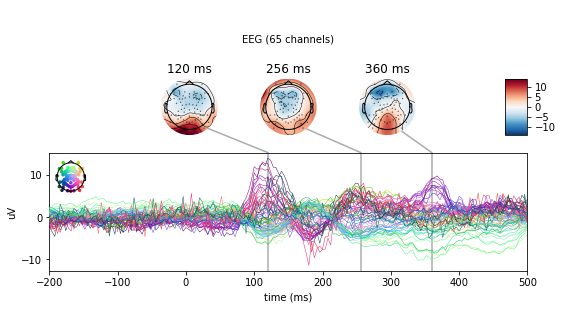

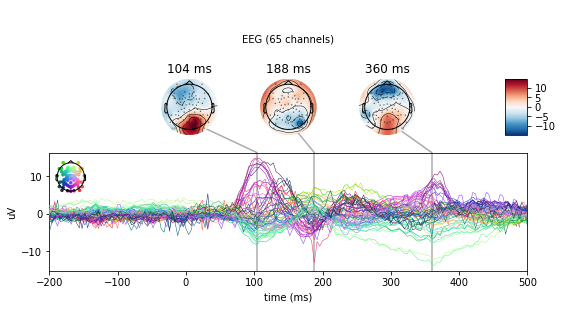

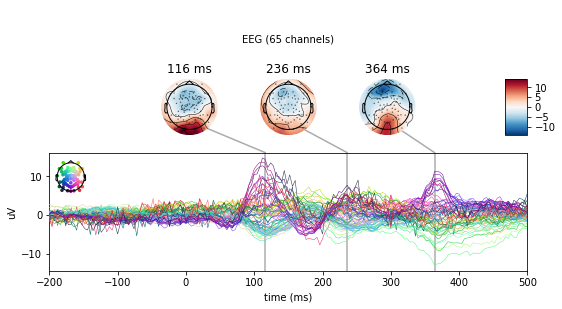

In [40]:
erp_auto_0.plot_joint();
erp_auto_90.plot_joint();
erp_auto_180.plot_joint();

Bez zaskoczenia: najwięcej dzieje się w załamku P100, charakterystycznym dla uwagi i bodźców wzrokowych. Szukam najlepszych elektrod dla wszystkich warunków. Poszukam trzech najlepszych, tak aby znaleźć jakiekolwiek wspólne:

In [43]:
pika_auto = Peakachu(mode='P100', n_channels=3)

**Auto w normalnej pozycji:**

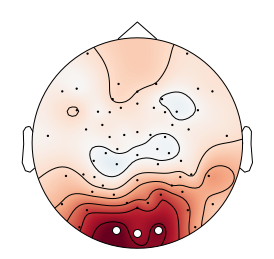

In [44]:
pika_auto.fit(erp_auto_0)
pika_auto.plot_topomap();

**Auto odwrócone o 90\*:**

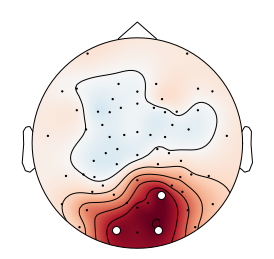

In [45]:
pika_auto.fit(erp_auto_90)
pika_auto.plot_topomap();

**Auto odwrócone o 180\*:**

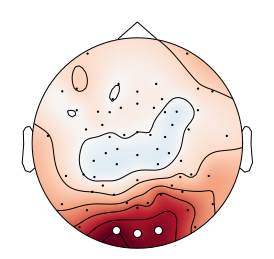

In [46]:
pika_auto.fit(erp_auto_180)
pika_auto.plot_topomap();

Ok, wybiorę 2 elektrody, które składają się na każdy warunek. Wyciągnę je z auta widzianego prosto, poprzez wybór dwóch najmocniejszych elektrod. Powinienem otrzymać te dwie elektrody po bokach, bez centralnej. Wyciągnę sobie również ich kanały i indeksy:

wybrane kanały to ['E39', 'E35']
ich indeksy to [38, 34]


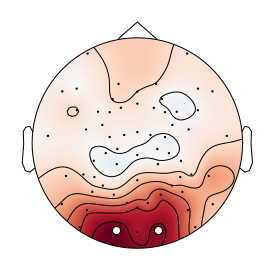

In [48]:
pika_auto = Peakachu(mode='P100', n_channels=2)
pika_auto.fit(erp_auto_0)
pika_auto.plot_topomap();
print("wybrane kanały to", pika_auto._chan_names)
print("ich indeksy to", pika_auto._chan_ind)

Wszystko zgodnie z założeniami; czas porównać te samochody! Ponieważ obiecałem, że będzie czytelnie - zaczynam od słownika:

In [51]:
auta = {'auto normalnie': erp_auto_0, 'auto odwrócone o 90*': erp_auto_90, 'auto odwrócone o 180*': erp_auto_180}

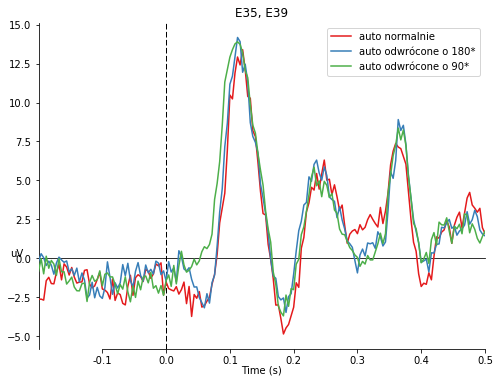

In [58]:
mne.viz.plot_compare_evokeds(auta, picks=[34, 38]);

!!!!!!!!!!!!!!!!!!! opisać wnioski po wywaleniu epok!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Bardzo, moim zdaniem, ciekawy wniosek: przeciętna reakcja na samochód widziany normalnie oraz odwócony o 180\* jest niemal taka sama. Znaczący wzrost w załamku P100 widzimy w przypadku auta odwróconego tylko(?) o 90\*. Później, w okolicach 360ms widzimy większą reakcję na auto odwrócone o 180\*.

### 7.2 porównanie ERP twarzy widocznych pod różnymi kątami:

Metoda będzie bardzo podobna, dlatego nie będę opisywał każdej komendy. Jedyna różnica: nie będę szukał ciekawych załamków, tylko od razu posłuże się obecnym stanem wiedzy i porównam charakterystyczną reakcję na twarz ludzką w postaci załamka N170.

In [53]:
erp_twarz_0 = epoki_erp['52'].average()
erp_twarz_90 = epoki_erp['56'].average()
erp_twarz_180 = epoki_erp['60'].average()

In [54]:
pika_twarz = Peakachu(mode='N170', n_channels=3)

**Twarz w normalnej pozycji:**

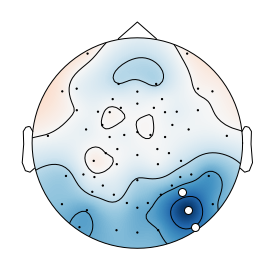

In [55]:
pika_twarz.fit(erp_twarz_0)
pika_twarz.plot_topomap();

**Twarz odwrócona o 90\*:**

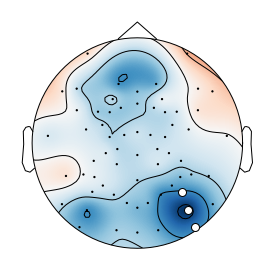

In [57]:
pika_twarz.fit(erp_twarz_90)
pika_twarz.plot_topomap();

**Twarz odwrócona o 180\*:**

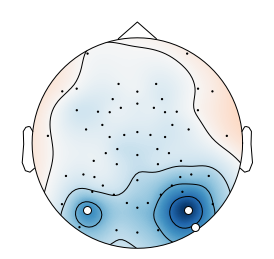

In [56]:
pika_twarz.fit(erp_twarz_180)
pika_twarz.plot_topomap();

Zakręt wrzecionowaty szaleje! ;) <br>Ponownie, wybieram dwie wspólne elektrody dla każdego warunku. Sprawdzam, czy szukając dwóch elektrod w twarzy odwróconej o 180\* zwróci mi te dwie elektrody z prawej strony.

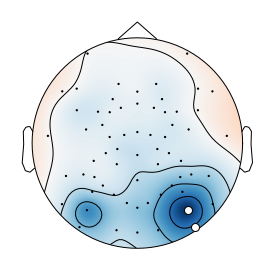

In [59]:
pika_twarz = Peakachu(mode='N170', n_channels=2)
pika_twarz.fit(erp_twarz_180)
pika_twarz.plot_topomap();

Super, w takim razie wyciągam ich pozycje i indeksy, a następnie porównuję.

In [60]:
print("wybrane kanały to", pika_twarz._chan_names)
print("ich indeksy to", pika_twarz._chan_ind)

wybrane kanały to ['E43', 'E44']
ich indeksy to [42, 43]


In [61]:
twarze = {'twarz normalnie': erp_twarz_0, 'twarz odwrócona o 90*': erp_twarz_90, 'twarz odwrócona o 180*': erp_twarz_180}

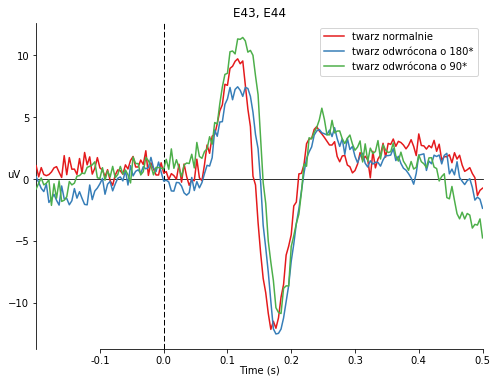

In [62]:
mne.viz.plot_compare_evokeds(twarze, picks=[42, 43]);

!!!!!!!!!!!!!wnioski po wyrzuceniu epok i ICA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Małe wnioski: po uśrednionych epokach widzę, że reakcja na twarz widzaną "prosto" była nieco mocniejsza. Potwierdza się również teoria o specyficznym załamku N170, rejestrowanym podczas oglądania twarzy. Tutaj również zaobserwowaliśmy mocniejszą oraz nieznacznie wcześniejszą reakcję.

### 7.3 porównanie ERP twarzy i samochodu widzianego prosto: